In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mpcol
import matplotlib as mpl
import osmnx as ox
import networkx as nx
import random
from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
%matplotlib inline

In [2]:
stations = pd.read_csv('Data/Stations.csv',index_col=0)
#stations['pos'] = (stations['latitude'],stations['longitude'])
stations.dropna(inplace=True)
stations['pos'] = list(zip(stations['longitude'],stations['latitude']))
stations.head()

,id,name,obcn,location,latitude,longitude,status,pos
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"(-103.34881999999999, 20.666377999999998)"
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"(-103.366, 20.667228)"
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"(-103.368252, 20.66769)"
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"(-103.36255, 20.69175)"
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"(-103.338863, 20.681151)"


In [3]:
trips = pd.read_csv('Data/datos_abiertos_2019_01.csv',parse_dates=True, infer_datetime_format=True)
trips['age']=2019-trips.iloc[:,3]
trips['Start']=pd.to_datetime(trips['Inicio_del_viaje'],infer_datetime_format=True)
trips['End']=pd.to_datetime(trips['Fin_del_viaje'],infer_datetime_format=True)
delta = trips['End']-trips['Start']
trips['Duration'] = delta.dt.seconds/60
trips['weekday'] = trips['Start'].dt.dayofweek
trips.tail()

,Viaje_Id,Usuario_Id,Genero,AÒo_de_nacimiento,Inicio_del_viaje,Fin_del_viaje,Origen_Id,Destino_Id,age,Start,End,Duration,weekday
405164,9366171,55004,M,1999.0,1/31/19 17:53,1/31/19 18:05,52,159,20.0,2019-01-31 17:53:00,2019-01-31 18:05:00,12.0,3
405165,9365791,55008,NaN,NaN,1/31/19 17:35,1/31/19 17:43,63,72,NaN,2019-01-31 17:35:00,2019-01-31 17:43:00,8.0,3
405166,9366836,55008,NaN,NaN,1/31/19 18:17,1/31/19 18:35,4,198,NaN,2019-01-31 18:17:00,2019-01-31 18:35:00,18.0,3
405167,9367398,55008,NaN,NaN,1/31/19 18:36,1/31/19 19:05,198,205,NaN,2019-01-31 18:36:00,2019-01-31 19:05:00,29.0,3
405168,9367861,55014,F,1995.0,1/31/19 18:52,1/31/19 19:15,75,276,24.0,2019-01-31 18:52:00,2019-01-31 19:15:00,23.0,3


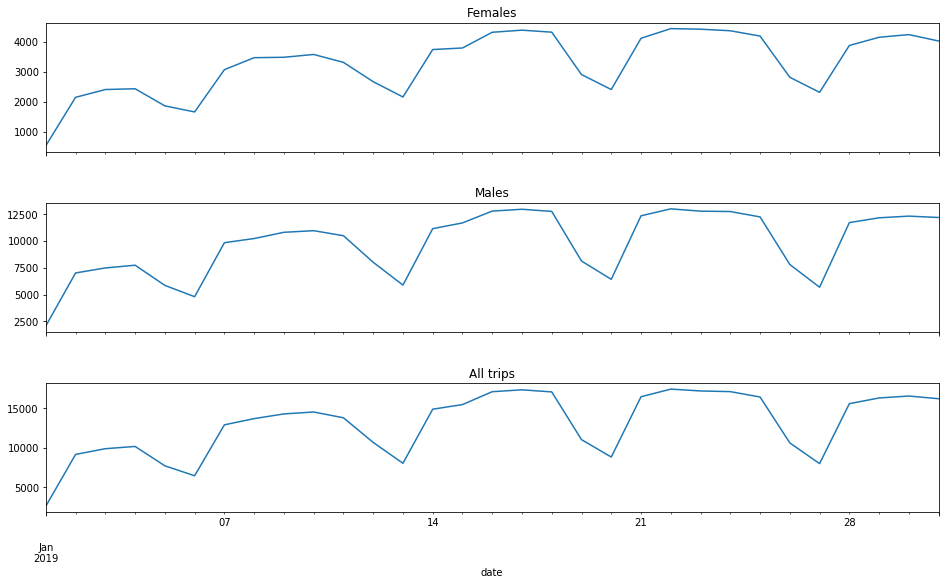

In [4]:
ind = pd.DatetimeIndex(trips.Start)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour
by_date = trips.pivot_table('Viaje_Id', aggfunc='count',
                            index='date',
                            columns='Genero', )
fig, ax = plt.subplots(3, figsize=(16, 9),sharex=True)
fig.subplots_adjust(hspace=0.4)
by_date.iloc[:, 0].plot(ax=ax[0], title='Females');
by_date.iloc[:, 1].plot(ax=ax[1], title='Males')
by_date['totals']= by_date.iloc[:, 1] + by_date.iloc[:, 0] 
by_date.iloc[:, 2].plot(ax=ax[2], title='All trips');

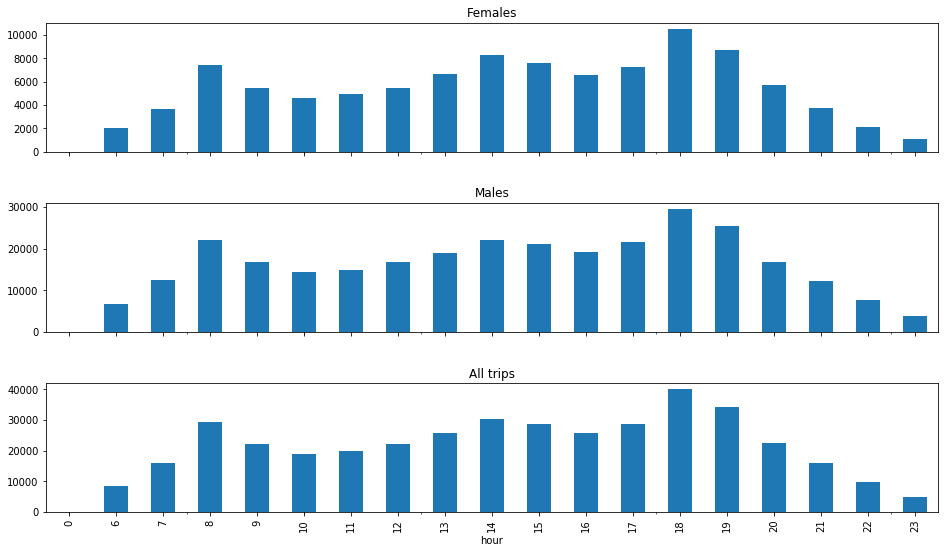

In [5]:
ind = pd.DatetimeIndex(trips.Start)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour
by_date = trips.pivot_table('Viaje_Id', aggfunc='count',
                            index='hour',
                            columns='Genero', )
fig, ax = plt.subplots(3, figsize=(16, 9),sharex=True)
fig.subplots_adjust(hspace=0.4)
by_date.iloc[:, 0].plot(ax=ax[0], title='Females',kind='bar');
by_date.iloc[:, 1].plot(ax=ax[1], title='Males',kind='bar');
by_date['totals']= by_date.iloc[:,1] + by_date.iloc[:,0] 
by_date.iloc[:, 2].plot(ax=ax[2], title='All trips', kind='bar');

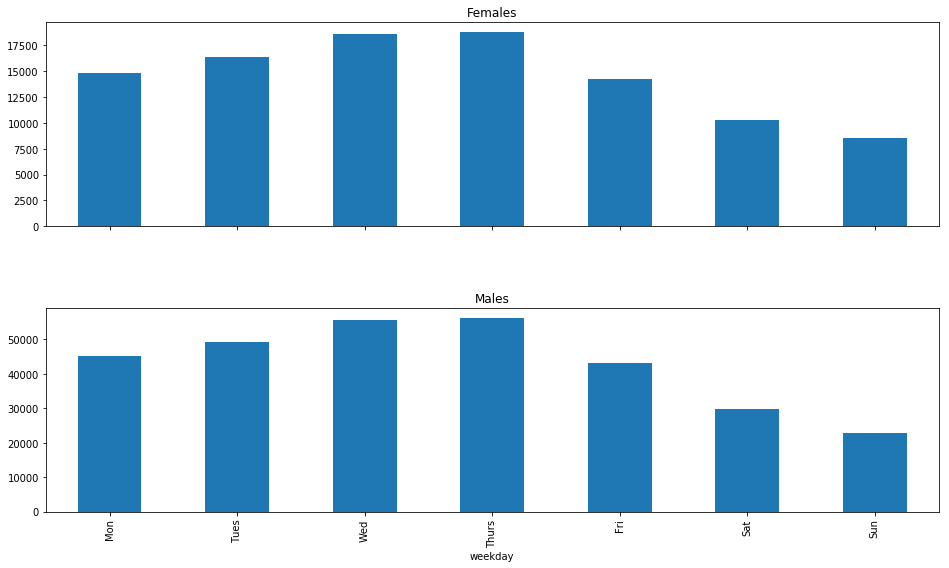

In [6]:
ind = pd.DatetimeIndex(trips.Start)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour
by_date = trips.pivot_table('Viaje_Id', aggfunc='count',
                            index='weekday',
                            columns='Genero', )
fig, ax = plt.subplots(2, figsize=(16, 9),sharex=True)
fig.subplots_adjust(hspace=0.4)
by_date.iloc[:, 0].plot(ax=ax[0], title='Females',kind='bar');
by_date.iloc[:, 1].plot(ax=ax[1], title='Males',kind='bar');
for axi in ax:
    axi.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']);

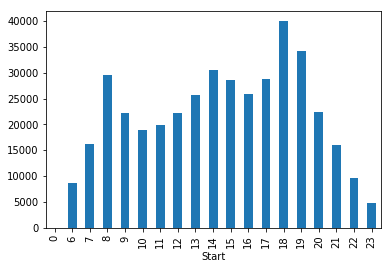

In [7]:
trips.groupby(trips["Start"].dt.hour)['Genero'].count().plot(kind="bar")

# Get GDL Map

In [8]:
GDL = ox.graph_from_bbox(20.746,20.62,-103.28,-103.42, network_type='bike')

# Get the data for graph

In [9]:
def filter_trips(trips, stations, date, hour):
    if hour > 0:
        trips_filter = trips[(trips['date'] == date) & (trips['hour'] == hour)]
    else:
        trips_filter = trips[(trips['date'] == date)]
    # Get the stations data
    by_date = trips_filter.pivot_table('Viaje_Id', aggfunc='count',
                                index='Origen_Id',
                                columns='Genero', dropna=False)
    by_date['total'] = by_date['F']+by_date['M']

    stations2 = stations.merge(by_date, how='left',left_on='id', right_index=True)
    stations2.sort_values('total',inplace=True, ascending=False)
    return trips_filter, stations2

In [10]:
def create_network_all(trips, stations):
    G = nx.DiGraph()
    for i, row in trips.iterrows():
        if G.has_edge(row['Origen_Id'],row['Destino_Id']) == False:
            G.add_edge(row['Origen_Id'],row['Destino_Id'], trips=1)
        else:
            G[row['Origen_Id']][row['Destino_Id']]['trips'] +=1
    pos = {}
    for i, n in stations.iterrows():
        pos[n['id']] = (n['longitude'], n['latitude'])
    nx.set_node_attributes(G,pos,'position')
    return G

In [11]:
def create_network(trips_filter, stations):
    G = nx.DiGraph()
    for i, row in trips_filter.iterrows():
        if G.has_edge(row['Origen_Id'],row['Destino_Id']) == False:
            G.add_edge(row['Origen_Id'],row['Destino_Id'], trips=1)
        else:
            G[row['Origen_Id']][row['Destino_Id']]['trips'] +=1
    pos = {}
    for i, n in stations.iterrows():
        pos[n['id']] = (n['longitude'], n['latitude'])
    nx.set_node_attributes(G,pos,'position')
    return G

In [12]:
def plot_Bike(GDL, stations2, G, date, hour):
    max_stations = stations2.total.max()
    trips_count=[e[2]['trips'] for e in G.edges(data=True)]
    trips_max = max(trips_count)
    fig, ax = ox.plot_graph(GDL,node_color='#aaaaaa', node_size=0, show=False, close=True, fig_height=20, edge_linewidth=0.1, bgcolor='#273238',edge_color='#efefef')
    nx.draw_networkx(G, pos=pos, with_labels=False, node_size=0, ax=ax, 
                     edge_color=[0.5+(e[2]['trips']/trips_max) for e in G.edges(data=True)], edge_cmap=plt.cm.YlOrRd, 
                     width=[0.08+(e[2]['trips']/trips_max) for e in G.edges(data=True)],arrows=False)
    sc = ax.scatter(stations2.longitude,stations2.latitude,c=stations2.total/max_stations, s=10*stations2['total'],alpha=1,cmap='plasma',zorder=2)
    ax.set_title('{} {}'.format(date, hour), pad=3, fontdict={'family':'DejaVu Sans', 'fontsize':45, 'fontweight':'normal', 'y':0.15, 'color':'white'})
    if hour < 10:
        fig.savefig('GIF/{}0{}.png'.format(date,hour),dpi=150,facecolor='#273238',constrained_layout=True)
    else:
        fig.savefig('GIF/{}{}.png'.format(date,hour),dpi=150,facecolor='#273238',constrained_layout=True)
    plt.close(fig)

# Plot network over city

In [142]:
dates = trips.date.unique()
days = [np.datetime64(np.datetime_as_string(i, timezone='local')[:10]) for i in dates]
days.sort()
hours = [i for i in range(6,24)]
for date in days:
    for hour in hours:
        trips_filter, stations2 = filter_trips(trips, stations, date, hour)
        G = create_network(trips_filter, stations)
        plot_Bike(GDL, stations2, G, date, hour)

KeyboardInterrupt: 

# Plot streets as edges

In [13]:
import matplotlib.cm as cm
import matplotlib

In [14]:
def closest_nodes(G, GDL):
    nodes_map = {}
    for n in G.nodes(data=True):
        nodes_map[n[0]] = ox.get_nearest_node(GDL,(n[1]['position'][1],n[1]['position'][0]))
    return nodes_map

In [15]:
def get_paths(G, nodes_map):
    paths = {}
    for e in G.edges(data=True):
        origin = nodes_map[e[0]]
        destination = nodes_map[e[1]]
        try:
            path = nx.shortest_path(GDL,origin,destination,weight='length')
            paths[(origin, destination)] = path
        except:
            pass
    return paths


def add_trips(GDL, G, nodes_map, paths):
    for i,j,data in GDL.edges(data=True):
        data['trips'] = 1
    for e in G.edges(data=True):
        origin = nodes_map[e[0]]
        destination = nodes_map[e[1]]
        try:
            path = paths[(origin,destination)]
            for i, j in zip(path[:-1], path[1:]):
                GDL[i][j][0]['trips'] += e[2]['trips']
        except:
            pass
    return GDL

In [23]:
def get_colors_widths(GDL):
    lst = [np.log(data['trips']) for i,j,data in GDL.edges(data=True)]
    minima = min(lst)
    maxima = max(lst)
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.YlOrRd)
    colors = [mapper.to_rgba(v) for v in lst]
    widths = [0.1 if data['trips'] < 2 else data['trips']/2 for i,j,data in GDL.edges(data=True)]
    return colors, widths

In [29]:
def plot_map(GDL, stations2, colors, widths, date, hour):
    max_stations = stations2.total.max()
    fig, ax = ox.plot_graph(GDL,node_color='#aaaaaa', node_size=0, show=False, close=True, fig_height=20, edge_linewidth=widths, bgcolor='#273238',edge_color=colors)
    sc = ax.scatter(stations2.longitude,stations2.latitude,c=stations2.total/max_stations, s=100*stations2['total'],alpha=0.8,cmap='Blues',zorder=2)
    ax.set_title('{} {}'.format(date, hour), pad=3, fontdict={'family':'DejaVu Sans', 'fontsize':45, 'fontweight':'normal', 'y':0.15, 'color':'white'})
    #fig.savefig('GIF_Map/{}.png'.format(date),dpi=150,facecolor='#273238',constrained_layout=True)
    if hour < 10:
        fig.savefig('GIF_Map_Day/{}0{}.png'.format(date,hour),dpi=150,facecolor='#273238',constrained_layout=True)
    else:
        fig.savefig('GIF_Map_Day/{}{}.png'.format(date,hour),dpi=150,facecolor='#273238',constrained_layout=True)
    plt.close(fig)

In [19]:
dates = trips.date.unique()
days = [np.datetime64(np.datetime_as_string(i, timezone='local')[:10]) for i in dates]
days.sort()

In [20]:
import time

1/465 elapsed time: 3.146 min. time for calculation: 188.76 s.
2/465 elapsed time: 6.426 min. time for calculation: 196.812 s.
3/465 elapsed time: 8.293 min. time for calculation: 112.008 s.
4/465 elapsed time: 9.403 min. time for calculation: 66.614 s.
5/465 elapsed time: 11.823 min. time for calculation: 145.172 s.
6/465 elapsed time: 12.769 min. time for calculation: 56.773 s.
7/465 elapsed time: 14.74 min. time for calculation: 118.272 s.
8/465 elapsed time: 16.418 min. time for calculation: 100.688 s.
9/465 elapsed time: 18.485 min. time for calculation: 124.003 s.
10/465 elapsed time: 20.487 min. time for calculation: 120.108 s.
11/465 elapsed time: 21.813 min. time for calculation: 79.592 s.
12/465 elapsed time: 24.143 min. time for calculation: 139.748 s.
13/465 elapsed time: 26.642 min. time for calculation: 149.976 s.
14/465 elapsed time: 28.164 min. time for calculation: 91.292 s.
15/465 elapsed time: 30.012 min. time for calculation: 110.912 s.
16/465 elapsed time: 32.873 m

KeyboardInterrupt: 

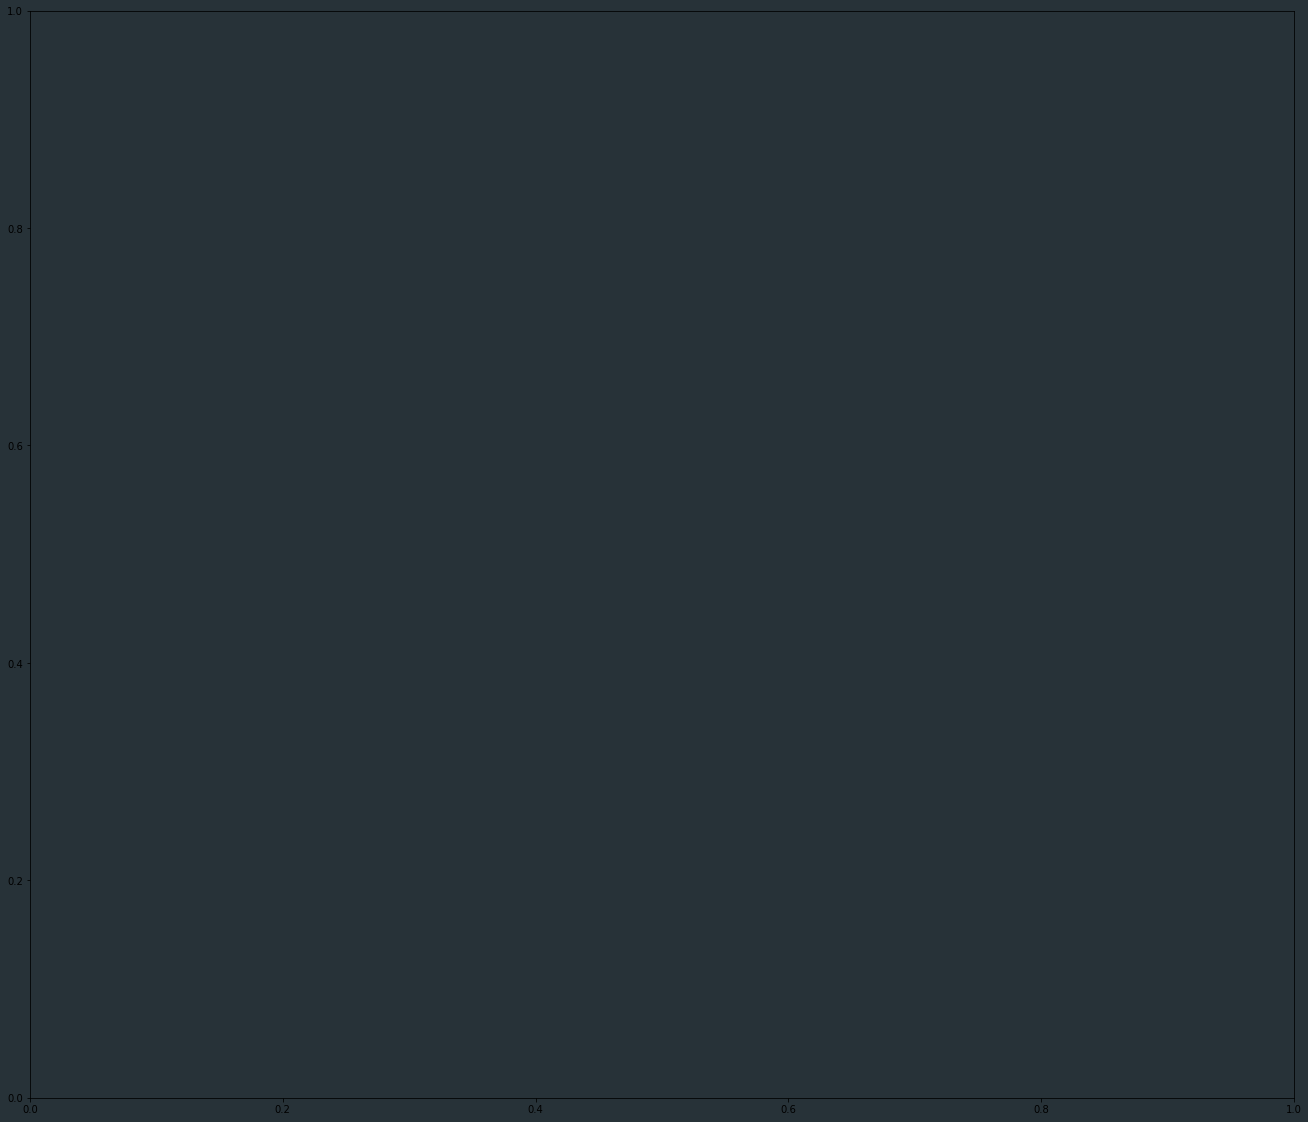

In [30]:
start_time = time.time()
step = 1
#G_all = create_network_all(trips, stations)
#nodes_map = closest_nodes(G_all, GDL)
#paths = get_paths(G_all, nodes_map)
hours = [i for i in range(6,24)]
for date in days:
    for hour in hours:
        start_temp = time.time()
        trips_filter, stations2 = filter_trips(trips, stations, date, hour)
        G = create_network(trips_filter, stations)
        GDL = add_trips(GDL, G, nodes_map, paths)
        colors, widths = get_colors_widths(GDL)
        plot_map(GDL, stations2, colors, widths, date, hour)
        print('{}/{} elapsed time: {} min. time for calculation: {} s.'.format(step,len(dates)*15,round((time.time()-start_time)/60,3),round(time.time()-start_temp,3)))
        step += 1